In [1]:
from pyspark.sql import SparkSession
from delta.pip_utils import configure_spark_with_delta_pip


builder = SparkSession.builder.appName("MiAppConDelta") \
    .master("local[*]") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("¡SparkSession con Delta Lake creada con éxito!")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/17 14:31:06 WARN Utils: Your hostname, Zidnz, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/17 14:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/zidnz/mi_proyecto_env/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/zidnz/.ivy2.5.2/cache
The jars for the packages stored in: /home/zidnz/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-16df62bf-53ef-4f4d-a7c6-799846ab99a1;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: resolve 439ms :: artifacts dl 7ms
	:: modules in use:
	io.d

¡SparkSession con Delta Lake creada con éxito!


In [2]:
ruta_lectura = "/home/zidnz/DanaPP/proyecto_fraude/deltaLake"

df_spark = spark.read.format("delta").load(ruta_lectura)

df_spark.show()

25/11/17 14:31:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+----------------+-------------+----------+--------+------+----------------+----------------+--------------+--------------------+-------------------+--------------------+------------+---------------+-----------------+--------------------+----------+---------------+
|id_transaccion|id_cliente|  nombre_cliente|cuenta_origen|     fecha|   monto|divisa|tipo_transaccion|          ciudad|cuenta_destino|           categoria|    hora_movimiento| concepto_movimiento|saldo_previo|saldo_posterior|canal_transaccion|          medio_pago|   estatus|fraude_probable|
+--------------+----------+----------------+-------------+----------+--------+------+----------------+----------------+--------------+--------------------+-------------------+--------------------+------------+---------------+-----------------+--------------------+----------+---------------+
|         27961|     18780|     Luis Garcia|      1.38E17|20/04/2025|  237.44|   MXN| Compra en linea|Ciudad de Mexico|     

In [3]:
print("--- 1. Verificar Schema y Tipos de Datos (Calidad) ---")
df_spark.printSchema()

(f"\nNúmero total de transacciones: {df_spark.count()}")

--- 1. Verificar Schema y Tipos de Datos (Calidad) ---
root
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- tipo_transaccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)



'\nNúmero total de transacciones: 200000'

In [4]:
from pyspark.sql.functions import col, when, to_date, hour

df_limpio = df_spark.filter(col("fraude_probable").isNotNull())

df_limpio = df_limpio.withColumn("es_fraude", 
    when(col("fraude_probable") == "Si", 1).otherwise(0)
)

In [5]:
print(f"Filas originales: {df_spark.count()}")
print(f"Filas después de limpiar NULLs: {df_limpio.count()}")

Filas originales: 200000
Filas después de limpiar NULLs: 200000


In [6]:
# --- 1.3. Convertir 'fecha' a tipo Date y extraer 'hora' ---
# 'fecha' es string, 'hora_movimiento' es timestamp
df_spark = df_spark.withColumn("fecha_dt", to_date(col("fecha"))) # Asume formato AAAA-MM-DD
df_spark = df_spark.withColumn("hora_del_dia", hour(col("hora_movimiento")))

print("Schema actualizado con 'es_fraude' y 'hora_del_dia':")
df_spark.printSchema()

Schema actualizado con 'es_fraude' y 'hora_del_dia':
root
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- tipo_transaccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)
 |-- fecha_dt: date (nullable = true)
 |-- hora_del_dia: integer (nullable = true)



In [7]:
from pyspark.sql.functions import count, col

total_registros_limpios = df_limpio.count()

# 2. Agrupamos por la nueva columna 'es_fraude'
df_limpio.groupBy("fraude_probable", "es_fraude") \
    .agg(
        count("*").alias("Total_Registros"),
        (count("*") / total_registros_limpios * 100).alias("Porcentaje")
    ) \
    .orderBy(col("es_fraude").desc()) \
    .show()

+---------------+---------+---------------+------------------+
|fraude_probable|es_fraude|Total_Registros|        Porcentaje|
+---------------+---------+---------------+------------------+
|             Si|        1|           5079|2.5395000000000003|
|             No|        0|         194921| 97.46050000000001|
+---------------+---------+---------------+------------------+



In [8]:
from pyspark.sql.functions import avg

print("--- 3.1. Tasa de Fraude por Tipo de Transacción ---")
df_limpio.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones") 
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.1. Tasa de Fraude por Tipo de Transacción ---
+--------------------+--------------------+-------------------+
|    tipo_transaccion|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|Transferencia int...|  0.2558956347215253|               3986|
|      Pago de nomina| 0.23548642758074104|              10094|
|            Deposito| 0.04910883579825559|              15822|
|       Transferencia|0.008695305332854692|              50142|
|     Compra en linea|0.004189544726607184|              69936|
|              Retiro|0.003728560775540...|              20115|
|    Pago de servicio|0.003377361645209831|              29905|
+--------------------+--------------------+-------------------+



In [9]:
print("--- 3.2. Tasa de Fraude por Canal de Transacción ---")
df_limpio.groupBy("canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.2. Tasa de Fraude por Canal de Transacción ---
+-----------------+--------------------+-------------------+
|canal_transaccion|         Tasa_Fraude|Total_Transacciones|
+-----------------+--------------------+-------------------+
|Sucursal bancaria| 0.07845670240709642|              23223|
|     Corresponsal| 0.04771730719628579|               3877|
|              Web|0.021446964033557604|              60195|
|        App movil|0.017993575551261215|              78139|
|Cajero automatico|0.016554946171033924|              19692|
|    Domiciliacion|0.003294339115234...|              14874|
+-----------------+--------------------+-------------------+



In [10]:
print("--- 3.3. Tasa de Fraude por Categoría de Comercio ---")
df_limpio.groupBy("categoria") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.3. Tasa de Fraude por Categoría de Comercio ---
+--------------------+--------------------+-------------------+
|           categoria|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|             Remesas| 0.25054602184087366|               3205|
|              Nomina| 0.23043124491456468|               6145|
|             Ingreso| 0.13174992011928852|               9389|
|              Ahorro| 0.05002315886984715|               6477|
|Transferencia per...|0.014324504045217777|              36092|
|             Consumo|0.006631381169333546|              81431|
|           Servicios|0.004482853086942445|              40153|
|            Efectivo|0.003624035538929156|              17108|
+--------------------+--------------------+-------------------+



In [11]:
from pyspark.sql.functions import col, avg, count

# PASO 1.A: Revisa los 'estatus' de esos fraudes de nómina
print("--- Estatus de los fraudes de 'Pago de nomina' ---")
df_limpio.filter(col("tipo_transaccion") == "Pago de nomina") \
    .groupBy("estatus", "fraude_probable") \
    .count() \
    .show()

# PASO 1.B: Re-calcula tu tasa SOLO para transacciones 'Completada'
print("--- Tasa de Fraude (Solo 'Completada') por Tipo ---")
df_completado = df_limpio.filter(col("estatus") == "Completada")

df_completado.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- Estatus de los fraudes de 'Pago de nomina' ---
+----------+---------------+-----+
|   estatus|fraude_probable|count|
+----------+---------------+-----+
|Completada|             Si| 2295|
| Cancelada|             No|  112|
| Rechazada|             Si|   31|
| Rechazada|             No|  107|
| Cancelada|             Si|   23|
| Pendiente|             No|  117|
| Pendiente|             Si|   28|
|Completada|             No| 7381|
+----------+---------------+-----+

--- Tasa de Fraude (Solo 'Completada') por Tipo ---
+--------------------+--------------------+-------------------+
|    tipo_transaccion|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|Transferencia int...|   0.252092050209205|               3824|
|      Pago de nomina|  0.2371847871021083|               9676|
|            Deposito|0.049024117763028195|              15217|
|       Transferencia|0.008637375902761878|              48047|
|     Compra en linea|0.0042

In [12]:
from pyspark.sql.functions import stddev, min, max

print("--- Análisis de Monto por Fraude (1 = Fraude) ---")
df_limpio.groupBy("es_fraude") \
    .agg(
        avg("monto").alias("monto_promedio"),
        stddev("monto").alias("monto_stddev"),
        min("monto").alias("monto_min"),
        max("monto").alias("monto_max")
    ) \
    .show()

--- Análisis de Monto por Fraude (1 = Fraude) ---
+---------+------------------+------------------+---------+---------+
|es_fraude|    monto_promedio|      monto_stddev|monto_min|monto_max|
+---------+------------------+------------------+---------+---------+
|        1|44318.581549517636|29159.361048703613|  1545.85| 99998.74|
|        0|  936.307703992898|1711.1324412832882|     50.0| 14966.01|
+---------+------------------+------------------+---------+---------+



In [13]:
from pyspark.sql.functions import hour

# 1. Crear la columna 'hora_del_dia' (asumo que tu schema la tiene)
df_con_hora = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento")))

# 2. Analizar tasa de fraude por hora
print("--- Tasa de Fraude por Hora del Día ---")
df_con_hora.groupBy("hora_del_dia") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy("hora_del_dia") \
    .show(24) # Mostrar las 24 horas

--- Tasa de Fraude por Hora del Día ---
+------------+--------------------+-------------------+
|hora_del_dia|         Tasa_Fraude|Total_Transacciones|
+------------+--------------------+-------------------+
|           0| 0.17490890161374284|               1921|
|           1| 0.18577866800200302|               1997|
|           2| 0.17894736842105263|               1995|
|           3| 0.16557624559637646|               1987|
|           4| 0.17700453857791226|               1983|
|           5| 0.15919395465994962|               1985|
|           6|                 0.0|               1677|
|           7|                 0.0|               1631|
|           8|                 0.0|               1622|
|           9| 0.03135444851185739|               6283|
|          10|0.019301470588235295|              10880|
|          11|0.013756260434056762|              14975|
|          12|0.009130789634768415|              19604|
|          13|0.007791666666666666|              24000|
|       

In [14]:
print("--- Interacción: Tipo de Transacción vs. Canal ---")
df_limpio.groupBy("tipo_transaccion", "canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show(truncate=False) # truncate=False para ver los nombres completos

--- Interacción: Tipo de Transacción vs. Canal ---
+---------------------------+-----------------+---------------------+-------------------+
|tipo_transaccion           |canal_transaccion|Tasa_Fraude          |Total_Transacciones|
+---------------------------+-----------------+---------------------+-------------------+
|Transferencia internacional|Sucursal bancaria|0.2577276524644946   |2394               |
|Transferencia internacional|Web              |0.25314070351758794  |1592               |
|Pago de nomina             |App movil        |0.23604622571920333  |4067               |
|Pago de nomina             |Web              |0.2355958958168903   |2534               |
|Pago de nomina             |Sucursal bancaria|0.23475522473518465  |3493               |
|Deposito                   |Sucursal bancaria|0.04972549019607843  |6375               |
|Deposito                   |Cajero automatico|0.04937163375224417  |5570               |
|Deposito                   |Corresponsal     |0.

In [15]:
from pyspark.sql.functions import col, avg, count, when, hour

# --- 1. Asegúrate de tener las 'features' de hora y monto ---
df_con_features = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento"))) \
                            .withColumn("es_monto_alto", 
                                when(col("monto") > 1500, 1).otherwise(0) # Usamos 1500 como umbral (basado en tu min_fraude)
                            )

print("--- Interacción: Tipo vs. Hora vs. Monto ---")
df_con_features.groupBy(
    "tipo_transaccion", 
    "hora_del_dia", 
    "es_monto_alto"
).agg(
    avg("es_fraude").alias("Tasa_Fraude"),
    count("*").alias("Total_Transacciones")
).orderBy(col("Tasa_Fraude").desc()) \
 .show(truncate=False)

--- Interacción: Tipo vs. Hora vs. Monto ---
+----------------+------------+-------------+-----------+-------------------+
|tipo_transaccion|hora_del_dia|es_monto_alto|Tasa_Fraude|Total_Transacciones|
+----------------+------------+-------------+-----------+-------------------+
|Retiro          |9           |1            |1.0        |5                  |
|Retiro          |1           |1            |1.0        |6                  |
|Compra en linea |3           |1            |1.0        |21                 |
|Compra en linea |14          |1            |1.0        |17                 |
|Compra en linea |23          |1            |1.0        |23                 |
|Compra en linea |22          |1            |1.0        |31                 |
|Compra en linea |1           |1            |1.0        |17                 |
|Pago de servicio|5           |1            |1.0        |7                  |
|Compra en linea |4           |1            |1.0        |18                 |
|Compra en linea |5

¿La tasa de fraude del 11% en "Transferencia" es igual en todos los canales (Web, App, Sucursal)? ¿O es que, por ejemplo, las "Transferencias por Web" tienen una tasa de fraude del 30% y las demás del 1%?

In [16]:
print("--- 4. Tasa de Fraude Cruzada: Tipo vs. Canal ---")

# Agrupar por AMBAS columnas
df_limpio.groupBy("tipo_transaccion", "canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show(50, truncate=False) # Mostramos más filas y sin truncar

--- 4. Tasa de Fraude Cruzada: Tipo vs. Canal ---
+---------------------------+-----------------+---------------------+-------------------+
|tipo_transaccion           |canal_transaccion|Tasa_Fraude          |Total_Transacciones|
+---------------------------+-----------------+---------------------+-------------------+
|Transferencia internacional|Sucursal bancaria|0.2577276524644946   |2394               |
|Transferencia internacional|Web              |0.25314070351758794  |1592               |
|Pago de nomina             |App movil        |0.23604622571920333  |4067               |
|Pago de nomina             |Web              |0.2355958958168903   |2534               |
|Pago de nomina             |Sucursal bancaria|0.23475522473518465  |3493               |
|Deposito                   |Sucursal bancaria|0.04972549019607843  |6375               |
|Deposito                   |Cajero automatico|0.04937163375224417  |5570               |
|Deposito                   |Corresponsal     |0.0

In [17]:
from pyspark.sql.functions import hour, to_date

df_con_tiempo = df_limpio.withColumn("fecha_dt", to_date(col("fecha")))
df_con_tiempo = df_con_tiempo.withColumn("hora_del_dia", hour(col("hora_movimiento")))


print("--- 5. Tasa de Fraude por Hora del Día ---")
df_con_tiempo.groupBy("hora_del_dia") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("hora_del_dia")) \
    .show(24)

--- 5. Tasa de Fraude por Hora del Día ---
+------------+--------------------+-------------------+
|hora_del_dia|         Tasa_Fraude|Total_Transacciones|
+------------+--------------------+-------------------+
|           0| 0.17490890161374284|               1921|
|           1| 0.18577866800200302|               1997|
|           2| 0.17894736842105263|               1995|
|           3| 0.16557624559637646|               1987|
|           4| 0.17700453857791226|               1983|
|           5| 0.15919395465994962|               1985|
|           6|                 0.0|               1677|
|           7|                 0.0|               1631|
|           8|                 0.0|               1622|
|           9| 0.03135444851185739|               6283|
|          10|0.019301470588235295|              10880|
|          11|0.013756260434056762|              14975|
|          12|0.009130789634768415|              19604|
|          13|0.007791666666666666|              24000|
|    

In [18]:
from pyspark.sql.functions import when, col

# --- 1. Crear las "banderas" de riesgo ---
df_con_banderas = df_con_tiempo.withColumn("es_horario_riesgo", 
        when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
    ).withColumn("es_tipo_riesgo", 
        when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
    ).withColumn("es_canal_riesgo", 
        when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
    )

# --- 2. Consulta de Validación Final ---
# Queremos ver si TODAS las transacciones de fraude (es_fraude == 1)
# tienen TODAS las banderas de riesgo en 1. 
print("--- 6. Validación Final de Reglas de Fraude ---")
df_con_banderas.groupBy(
    "es_fraude", 
    "es_horario_riesgo", 
    "es_tipo_riesgo",
    "es_canal_riesgo"
).agg(
    count("*").alias("Total_Transacciones")
).orderBy(col("es_fraude").desc(), col("Total_Transacciones").desc()) \
 .show()

--- 6. Validación Final de Reglas de Fraude ---
+---------+-----------------+--------------+---------------+-------------------+
|es_fraude|es_horario_riesgo|es_tipo_riesgo|es_canal_riesgo|Total_Transacciones|
+---------+-----------------+--------------+---------------+-------------------+
|        1|                0|             0|              1|               2038|
|        1|                1|             0|              1|               1025|
|        1|                0|             1|              1|                938|
|        1|                1|             1|              1|                518|
|        1|                0|             0|              0|                359|
|        1|                1|             0|              0|                201|
|        0|                0|             0|              1|             100039|
|        0|                0|             1|              1|              50474|
|        0|                0|             0|              0| 

In [19]:
from pyspark.sql.functions import col, when, hour

# --- 1. Feature de Horario de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
)

In [20]:
# --- 2. Feature de Tipo de Transacción de Riesgo ---
df_features = df_features.withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
)

In [21]:
# --- 3. Feature de Canal de Riesgo ---
df_features = df_features.withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

In [22]:
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

In [23]:
from pyspark.sql.functions import avg, log

# --- 5. Feature Log(Monto) ---
# (Sumamos 1 para evitar errores si el monto es 0)
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

In [24]:
# --- 6. Feature de Ratio del Monto ---
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

In [25]:
# 2. Unimos (join) estos promedios de vuelta a nuestro DataFrame principal
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")


In [26]:
# 3. Creamos el ratio (Monto / Monto Promedio del Tipo)
#    (Manejamos división por cero por si acaso)
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# --- 7. Codificación Categórica ---
# Lista de columnas categóricas que queremos usar
columnas_categoricas = ["canal_transaccion", "tipo_transaccion", "categoria", "divisa", "ciudad", "medio_pago"]

# Nombres de salida para las columnas indexadas
columnas_indexadas = [c + "_idx" for c in columnas_categoricas]

# Nombres de salida para las columnas codificadas (One-Hot)
columnas_onehot = [c + "_ohe" for c in columnas_categoricas]

# 1. Crear el StringIndexer
indexer = StringIndexer(inputCols=columnas_categoricas, outputCols=columnas_indexadas)

# 2. Crear el OneHotEncoder
encoder = OneHotEncoder(inputCols=columnas_indexadas, outputCols=columnas_onehot)


In [28]:
from pyspark.sql.functions import col, when, hour, avg, log

# --- 0. Asegúrate de tener las columnas de tiempo ---
# (Esto asume que 'df_limpio' existe)
df_con_tiempo = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento")))

# --- 1. Crear Banderas de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
).withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
).withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

# --- 2. Crear "Golden Feature" (Interacción) ---
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

# --- 3. Features de Monto (Log y Ratio) ---
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

# 3.1 Calcular promedios por tipo
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

# 3.2 Unir (join) los promedios
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")

# 3.3 Crear el ratio
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)


# --- 4. MOSTRAR LOS CAMBIOS ---
# Seleccionamos algunas columnas originales Y todas las nuevas 'feat_'
print("DataFrame con las nuevas características:")
df_features.select(
    "es_fraude",
    "monto",
    "hora_del_dia",
    "tipo_transaccion",
    "canal_transaccion",
    "feat_horario_riesgo",     # Nueva
    "feat_tipo_riesgo",        # Nueva
    "feat_canal_riesgo",       # Nueva
    "feat_perfil_riesgo_completo", # Nueva
    "feat_log_monto",          # Nueva
    "feat_ratio_monto_vs_tipo" # Nueva
).show()

DataFrame con las nuevas características:
+---------+--------+------------+----------------+-----------------+-------------------+----------------+-----------------+---------------------------+------------------+------------------------+
|es_fraude|   monto|hora_del_dia|tipo_transaccion|canal_transaccion|feat_horario_riesgo|feat_tipo_riesgo|feat_canal_riesgo|feat_perfil_riesgo_completo|    feat_log_monto|feat_ratio_monto_vs_tipo|
+---------+--------+------------+----------------+-----------------+-------------------+----------------+-----------------+---------------------------+------------------+------------------------+
|        0|   94.32|          10|Pago de servicio|    Domiciliacion|                  0|               0|                0|                          0| 4.557239652230542|     0.32853639694514236|
|        1|51494.43|          16|  Pago de nomina|        App movil|                  0|               0|                1|                          0|10.849248344850313|    

In [28]:
from pyspark.sql.functions import col

# --- 1. Definir "label" (verdad) y "prediction" (nuestra regla) ---
# Usaremos el DataFrame 'df_features' que ya tiene la regla calculada
df_eval_reglas = df_features.withColumnRenamed("es_fraude", "label") \
                            .withColumnRenamed("feat_perfil_riesgo_completo", "prediction")

# --- 2. Calcular la Matriz de Confusión de la REGLA ---
tp = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 1)).count()
tn = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 0)).count()
fp = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 1)).count()
fn = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 0)).count()

print("--- Evaluación del Modelo de Reglas (Baseline) ---")
print(f"Verdaderos Positivos (Regla acierta fraude): {tp}")
print(f"Verdaderos Negativos (Regla acierta no-fraude): {tn}")
print("---------------------------------------------------")
print(f"Falsos Positivos (Regla molesta a cliente): {fp}")
print(f"Falsos Negativos (Regla deja pasar fraude): {fn}")

# --- 3. Calcular Métricas Clave de la REGLA ---
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nPrecisión de la Regla: {precision:.2%}")
print(f"Recall de la Regla: {recall:.2%}")

--- Evaluación del Modelo de Reglas (Baseline) ---
Verdaderos Positivos (Regla acierta fraude): 518
Verdaderos Negativos (Regla acierta no-fraude): 192723
---------------------------------------------------
Falsos Positivos (Regla molesta a cliente): 2198
Falsos Negativos (Regla deja pasar fraude): 4561

Precisión de la Regla: 19.07%
Recall de la Regla: 10.20%


In [29]:
from pyspark.sql.functions import avg, min, max, stddev

# --- 1. Aislar los Falsos Positivos de la Regla (Inocentes) ---
df_falsos_positivos = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 1))

print(f"--- Análisis de {fp} Falsos Positivos (Clientes Inocentes Molestados) ---")
df_falsos_positivos.select(
    avg("monto").alias("monto_avg"),
    min("monto").alias("monto_min"),
    max("monto").alias("monto_max"),
    stddev("monto").alias("monto_stddev")
).show()

# --- 2. Aislar los Verdaderos Positivos (Fraudes Reales) ---
df_verdaderos_positivos = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 1))

print(f"--- Análisis de {tp} Verdaderos Positivos (Fraudes Reales Atrapados) ---")
df_verdaderos_positivos.select(
    avg("monto").alias("monto_avg"),
    min("monto").alias("monto_min"),
    max("monto").alias("monto_max"),
    stddev("monto").alias("monto_stddev")
).show()

--- Análisis de 2198 Falsos Positivos (Clientes Inocentes Molestados) ---
+------------------+---------+---------+-----------------+
|         monto_avg|monto_min|monto_max|     monto_stddev|
+------------------+---------+---------+-----------------+
|1132.7013466787987|   100.12|  4903.97|779.6334064187494|
+------------------+---------+---------+-----------------+

--- Análisis de 518 Verdaderos Positivos (Fraudes Reales Atrapados) ---
+-----------------+---------+---------+------------------+
|        monto_avg|monto_min|monto_max|      monto_stddev|
+-----------------+---------+---------+------------------+
|44133.37916988417|   5000.0|  99998.7|29660.612809257615|
+-----------------+---------+---------+------------------+



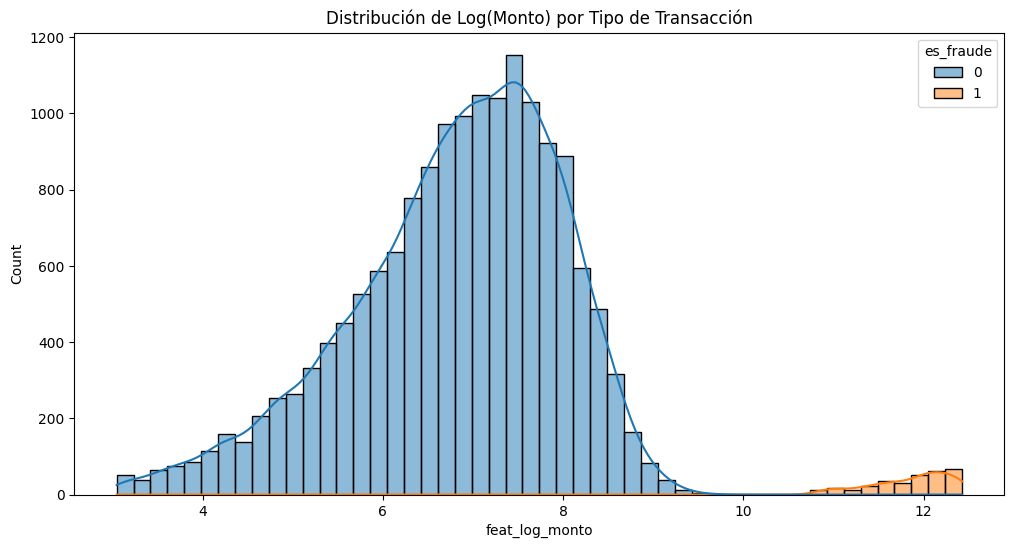

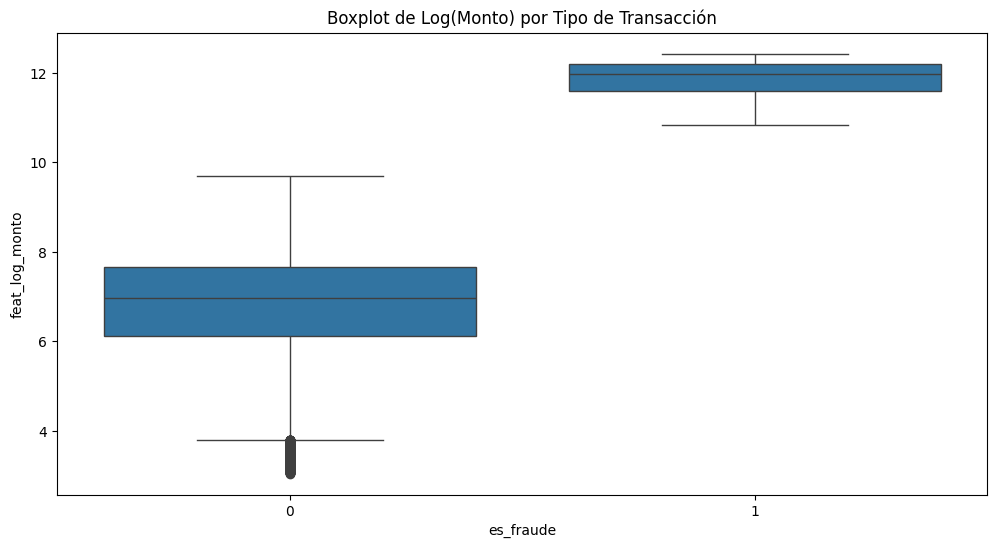

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Tomar una muestra de los datos ---
# (Graficar 150k+ puntos es lento, tomamos una muestra)
# Usaremos 'df_features' que tiene 'es_fraude' y 'feat_log_monto'
df_sample_pd = df_features.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# --- 2. Histograma de Log(Monto) ---
plt.figure(figsize=(12, 6))
sns.histplot(data=df_sample_pd, x="feat_log_monto", hue="es_fraude", kde=True, bins=50)
plt.title("Distribución de Log(Monto) por Tipo de Transacción")
plt.show()

# --- 3. Boxplot (Diagrama de Cajas) ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sample_pd, x="es_fraude", y="feat_log_monto")
plt.title("Boxplot de Log(Monto) por Tipo de Transacción")
plt.show()

In [32]:
# %%
from pyspark.sql.functions import col, when, hour, avg, log, to_date

# --- 0. CORRECCIÓN APLICADA AQUÍ ---
# Le decimos a 'to_date' que el formato es 'día/mes/año'
df_con_tiempo = df_limpio.withColumn("fecha_dt", to_date(col("fecha"), "dd/MM/yyyy")) \
                         .withColumn("hora_del_dia", hour(col("hora_movimiento")))

# --- 1. Crear Banderas de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
).withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
).withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

# --- 2. Crear "Golden Feature" (Interacción) ---
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

# --- 3. Features de Monto (Log y Ratio) ---
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

# 3.1 Calcular promedios por tipo
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

# 3.2 Unir (join) los promedios
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")

# 3.3 Crear el ratio
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)

print("DataFrame 'df_features' re-creado con la corrección de fecha.")

DataFrame 'df_features' re-creado con la corrección de fecha.


In [34]:
# %%
# Este código no cambia, pero ahora funcionará
ruta_escritura_features = "/home/zidnz/DanaPP/proyecto_fraude/delta_lake_features"

print(f"Guardando el DataFrame con features en: {ruta_escritura_features}")

df_features.write \
    .format("delta") \
    .mode("overwrite") \
    .save(ruta_escritura_features)

print("¡Tabla de features guardada con éxito!")

Guardando el DataFrame con features en: /home/zidnz/DanaPP/proyecto_fraude/delta_lake_features


25/11/17 14:47:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


¡Tabla de features guardada con éxito!
